In [1]:
import goes2go
import pandas as pd
import numpy as np
import xarray as xr
from goes2go import GOES
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

import fsspec
fs = fsspec.filesystem('s3', anon=True)
fsspec_caching = {
    "cache_type": "blockcache",  # block cache stores blocks of fixed size and uses eviction using a LRU strategy.
    "block_size": 8
    * 1024
    * 1024,  # size in bytes per block, adjust depends on the file size but the recommended size is in the MB
}

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/esl3d-env/lib/python3.10/site-packages/goes2go/data.py:665: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),
/opt/anaconda3/envs/esl3d-env/lib/python3.10/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),


#### Find all files between launch of satellite and now

We need to write a loop around this, since the goes2go searching across long time periods is pretty slow. I also noticed that `goes2go.goes_nearesttime` takes way longer than searching for a timerange.

In [171]:
abi_files = goes2go.goes_timerange(
    start=datetime(2023, 4, 1, 10, 00), 
    end=datetime(2023, 4, 1, 11, 00),
    download=False,
    domain='F',
    product="ABI-L2-MCMIP",
)

#### Other Data Products

In [ ]:
# Cloud height at 2 km

acha_files = goes2go.goes_timerange(
    start=datetime(2023, 4, 1, 10, 00), 
    end=datetime(2023, 4, 1, 11, 00),
    download=False,
    # domain='F',
    product="ABI-L2-ACHA2KMF",
)

In [ ]:
# Cloud pressure at 2 km

achp_files = goes2go.goes_timerange(
    start=datetime(2023, 4, 1, 10, 00), 
    end=datetime(2023, 4, 1, 11, 00),
    download=False,
    # domain='F',
    product="ABI-L2-ACHP2KMF",
)

In [162]:
# Cloud optical depth at 2 km

cod_files = goes2go.goes_timerange(
    start=datetime(2023, 4, 1, 10, 00), 
    end=datetime(2023, 4, 1, 11, 00),
    download=False,
    # domain='F',
    product="ABI-L2-COD2KMF",
)

In [155]:
# Cloud temperature at 2 km

acht_files = goes2go.goes_timerange(
    start=datetime(2020, 3, 1, 10, 00), 
    end=datetime(2020, 3, 1, 11, 00),
    download=False,
    # domain='F',
    product="ABI-L2-ACHTF",
)

In [156]:
# Clear sky mask at 2 km

acm_files = goes2go.goes_timerange(
    start=datetime(2022, 4, 1, 10, 00), 
    end=datetime(2022, 4, 1, 11, 00),
    download=False,
    # domain='F',
    product="ABI-L2-ACMF",
)

In [157]:
# Cloud phase at 2 km

actp_files = goes2go.goes_timerange(
    start=datetime(2022, 4, 1, 10, 00), 
    end=datetime(2022, 4, 1, 11, 00),
    download=False,
    # domain='F',
    product="ABI-L2-ACTPF",
)

In [158]:
# Cloud particle size at 2 km

cps_files = goes2go.goes_timerange(
    start=datetime(2022, 3, 1, 10, 00), 
    end=datetime(2022, 3, 1, 11, 00),
    download=False,
    # domain='F',
    product="ABI-L2-CPSF",
)

#### Open example file

In [172]:
index = 0
goes_data = xr.open_dataset(fs.open(abi_files['file'][index], **fsspec_caching), engine="h5netcdf")

In [173]:
goes_data

<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float64 0.1518 ... -0.1518
  * x                                       (x) float64 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2023-04-01T10:10:01.8Z
    time_coverage_start:       2023-04-01T10:00:20.3Z
    time_coverage_end:         2023-04-01T10:09:52.4Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        99ee95fe-8226-4642-9623-9aac02f45117

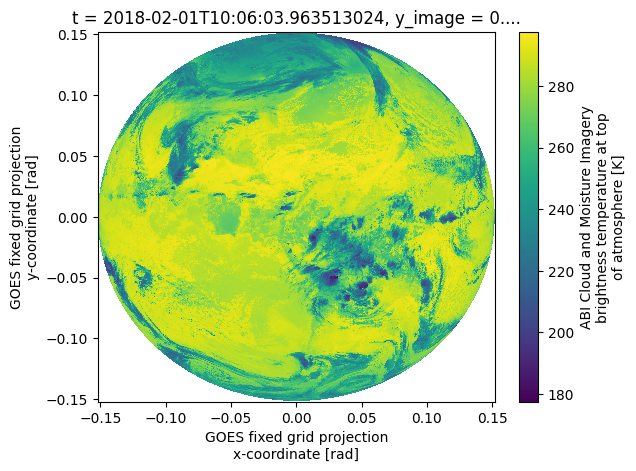

In [17]:
goes_data.CMI_C14.plot()

#### Create sub-patch from full-disk

- Mask percentage of full disk
- Sample with bias towards the center

In [177]:
ds = goes_data

In [174]:
def create_fov_mask(shape, fov_radius):
    """
    Function to create mask for specified field of view.
    """
    # Create coordinate grids
    y, x = np.ogrid[:shape[0], :shape[1]]
    # Calculate center points
    center_y, center_x = shape[0] // 2, shape[1] // 2
    # Calculate distance from center for each point
    dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    # Normalize distances by max possible distance (corner to center)
    max_dist = np.sqrt((center_x)**2 + (center_y)**2)
    normalized_dist = dist_from_center / max_dist
    # Create mask for specified field of view
    mask = normalized_dist <= fov_radius
    return mask

In [214]:
def check_quality_flags(ds):
    """
    Function to check quality flags in the dataset.
    0 --> good pixel quality
    1 --> conditionally usable pixel quality
    2 --> out of range pixel quality
    3 --> no value pixel quality
    4 --> focal plane temperature threshold exceeded pixel quality
    """
    # Check each channel individually - exit early if bad quality found
    for i in range(1, 17):
        if (ds[f'DQF_C{i:02d}'] > 1).any().item():
            return False
    return True

In [218]:
class CenterWeightedCropDatasetEditor():
    def __init__(self, patch_shape, fov_radius=0.6, max_attempts=10):
        self.patch_shape = patch_shape
        self.fov_radius = fov_radius
        self.max_attempts = max_attempts
    def __call__(self, ds):
        assert ds['x'].shape[0] >= self.patch_shape[0], 'Invalid dataset shape: %s' % str(ds['x'].shape)
        assert ds['y'].shape[0] >= self.patch_shape[1], 'Invalid dataset shape: %s' % str(ds['y'].shape)

        # get x/y grid
        x_grid, y_grid = np.meshgrid(np.arange(0, ds.x.shape[0], 1), np.arange(0, ds.y.shape[0], 1))

        # create mask for valid coordinates within desired field of view
        # NOTE: This masks from the center to the image edge, rather than disk edge
        valid_mask = create_fov_mask(shape=(ds.x.shape[0], ds.y.shape[0]), fov_radius=self.fov_radius)

        # get coordinate pairs for valid points
        coords_on_disk = np.column_stack((x_grid[valid_mask], y_grid[valid_mask]))
        del x_grid, y_grid

        attempts = 0
        while attempts <= self.max_attempts:
            # pick random x/y index
            random_idx = np.random.randint(0, len(coords_on_disk))
            x, y = tuple(coords_on_disk[random_idx])
            # define patch boundaries
            xmin = x - self.patch_shape[0] // 2
            ymin = y - self.patch_shape[1] // 2
            xmax = x + self.patch_shape[0] // 2
            ymax = y + self.patch_shape[1] // 2

            # crop patch
            patch_ds = ds.sel({'x': slice(ds['x'][xmin], ds['x'][xmax - 1]),
                                'y': slice(ds['y'][ymin], ds['y'][ymax - 1])})
            # check data quality flags
            if check_quality_flags(patch_ds) == False:
                print('Found patch with bad quality flags, trying again...')
                # try new set of indices
                attempts += 1
                continue   
            else:
                # exit loop and return patch
                return patch_ds, xmin, ymin

        print('Could not find patch without bad quality flags after %d cropping attempts' % self.max_attempts)

In [219]:
patch_size = 1024

crop = CenterWeightedCropDatasetEditor(patch_shape=(patch_size, patch_size), fov_radius=0.6)
patch_ds, xmin, ymin = crop(ds)

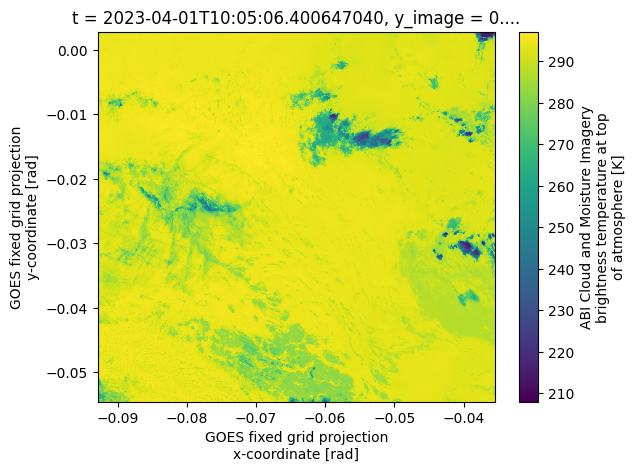

In [ ]:
patch_ds.CMI_C01.plot()